In [4]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [ ]:
subjs, subjs_data = [202509, 'tori', 'amisha', 'adam', 'erfan'], []
for subj in subjs:
    df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*csv')[0])[:-1]
    subjs_data.append(df_subj)

df_subjs = pd.concat(subjs_data, ignore_index=True)
assert len(df_subjs) == 0 or df_subjs['subj'].nunique() == len(subjs), "#rows != #subjs * #trials"
print(df_subjs.columns.tolist())
df_subjs

['thisN', 'thisTrialN', 'thisRepN', 'blockN', 'run', 'condition', 'trial_key', 'stim_file_pos', 'stim_pos', 'noise_pos', 'marker_init', 'shape', 'shape_order', 'div_pos', 'target_pos', 'subj_C0F1_val', 'subj_C1F0_val', 'target_file', 'img1_file', 'img2_file', 'block_start_resp.keys', 'block_start_resp.rt', 'block_start_resp.duration', 'marker.response', 'marker.rt', 'slider_resp.keys', 'slider_resp.rt', 'slider_resp.duration', 'submit_resp.keys', 'submit_resp.rt', 'submit_resp.duration', 'blocks.thisRepN', 'blocks.thisTrialN', 'blocks.thisN', 'blocks.thisIndex', 'trials.thisRepN', 'trials.thisTrialN', 'trials.thisN', 'trials.thisIndex', 'thisRow.t', 'notes', 'block_start.started', 'block_start_text.started', 'block_start_resp.started', 'block_start.stopped', 'blocks.block_start_resp.keys', 'blocks.block_start_resp.rt', 'blocks.block_start_resp.duration', 'baseline.started', 'ISI1.started', 'baseline.stopped', 'stim.started', 'target_stim.started', 'target_stim.stopped', 'stim.stopped',

,thisN,thisTrialN,thisRepN,blockN,run,condition,trial_key,stim_file_pos,stim_pos,noise_pos,...,Mcoin.started,Mcoin.stopped,Lcross.started,Rcross.started,Lcross.stopped,Rcross.stopped,Mcross.started,Mcross.stopped,Unnamed: 115,Unnamed: 122
0,0.0,0.0,0.0,1.0,1.0,baseline,10.0,1.1,-0.18,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,1.0,0.0,1.0,1.0,baseline,7.0,0.7,-0.26,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2.0,2.0,0.0,1.0,1.0,baseline,37.0,3.7,0.34,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3.0,3.0,0.0,1.0,1.0,baseline,14.0,1.5,-0.10,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4.0,4.0,0.0,1.0,1.0,baseline,8.0,0.9,-0.22,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,35.0,35.0,0.0,6.0,2.0,flat_comp,210.0,2.1,0.02,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1196,36.0,36.0,0.0,6.0,2.0,flat_comp,212.0,2.3,0.06,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1197,37.0,37.0,0.0,6.0,2.0,flat_comp,218.0,2.9,0.18,4.0,...,2112.874905,2113.875868,NaN,NaN,NaN,NaN,2112.874905,2113.875868,NaN,NaN
1198,38.0,38.0,0.0,6.0,2.0,flat_comp,238.0,3.9,0.38,0.0,...,2119.716484,2120.717329,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## preprocess

In [80]:
df_subjs = pd.DataFrame()
subj = '202509.0'

# init new cols
for col in ['dir_flip', 'sess_flip',
            'chosen_pos_aligned', 'div_pos_aligned', 'stim_pos_aligned',
            'class_true', 'class_pred', 'err_type',
            'right_bias', 'abs_diff_pos', 'normed_RT']:
    df_subjs[col] = np.nan

for subj in subjs:
    
    df_subj = pd.read_csv(glob.glob(f'../results/*{subj}*')[0])[:240]
    
    df_subj = df_subj.sort_values(by='trial_key').reset_index(drop=True)
    assert df_subj['trial_key'].is_monotonic_increasing, 'trial_key is not sorted correctly'

    df_subj['class_true'] = np.where( df_subj['valence'] == 'rew', 1, 0 )
    assert df_subj['class_true'].sum() == len(df_subj)/2, 'class_true is imbalanced'

    # convert str to list, and store chosen position
    for col in ['positions']:
        if type(df_subj[col][0]) == str:
            df_subj.loc[:, col] = df_subj[col].apply(ast.literal_eval)
            
    df_subj['chosen_pos'] = df_subj['positions'].apply(lambda x: x[-1])
    
## must sequentially align for flips & sessions because of the double flip situations

# 1. aligning for direction flips
    df_subj['dir_flip'] = (df_subj['shape_order'] == 'flat_curv').astype(int)
    assert df_subj['dir_flip'].sum() == len(df_subj)/2
   
   # align positions to curv=left, flat=right
    for col_prefix in ['chosen_pos', 'div_pos']: # dont need to unflip stim_pos because target_pos actually gets flipped
        df_subj[col_prefix + '_aligned'] = np.where( df_subj['dir_flip'],
                                                     -df_subj[col_prefix], df_subj[col_prefix] )

# 2. aligning for session type (stim-val association)
    if df_subj['sess_type'][0] in ['A', 'C']: # adam, tori       
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'pen_comp', 'flat_comp':'rew_comp'})
        df_subj['sess_flip'] = 0
        df_subj['stim_pos_aligned'] = df_subj['stim_pos']

    elif df_subj['sess_type'][0] in ['B', 'D']: # amisha, erfan     
        df_subj['condition'] = df_subj['condition'].map({'baseline':'baseline', 'curv_comp':'rew_comp', 'flat_comp':'pen_comp'})
        df_subj['sess_flip'] = 1
        df_subj['stim_pos_aligned'] = -df_subj['stim_pos']

        # align positions to penalty=left, reward=right
        for col in ['chosen_pos_aligned', 'div_pos_aligned']:
            df_subj[col] = -df_subj[col]

    df_subj['class_pred'] = (df_subj['chosen_pos_aligned'] > df_subj['div_pos_aligned']).astype(int)
    df_subj['err_type'] = df_subj['class_pred'] - df_subj['class_true']

    df_subjs = pd.concat([df_subjs, df_subj], ignore_index=True)

# if slider not moved or submitted
df_subjs = df_subjs.dropna(subset=['slider_resp.keys', 'submit_resp.keys'])

# accounting for older versions where large outcome was +-2
df_subjs['outcome'] = df_subjs['outcome'].replace({2: 3, -2: -3})

# calculate pred-true
df_subjs['right_bias'] = df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']
df_subjs['abs_diff_pos'] = (df_subjs['chosen_pos_aligned'] - df_subjs['stim_pos_aligned']).abs()

# RT normed by distance moved
df_subjs['normed_RT'] = df_subjs['trials.submit_resp.rt']/ (df_subjs['abs_diff_pos'] + .01)

df_subjs = df_subjs.copy()

print(df_subjs['outcome'].value_counts(), '\n')
print(df_subjs.shape, '\n')

disp_cols = ['sess_type', 'sess_flip', 'shape_order', 'dir_flip', 'target_pos', 'shape', 'valence', 'class_true',
             'div_pos', 'div_pos_aligned', 'stim_pos', 'stim_pos_aligned', 'chosen_pos', 'chosen_pos_aligned', 'class_pred', 'err_type',
             'right_bias', 'abs_diff_pos']

df_subjs[(df_subjs['sess_type'] == 'B') &
         (df_subjs['condition'] == 'baseline') &
         (df_subjs['err_type'] != 0) &
         (df_subjs['sess_flip'] != df_subjs['dir_flip'])
        ][disp_cols][:30]

# asserts

df_subjs.to_csv('../results/all_subjs_clean.csv', index=False)

outcome
 1.0    472
 3.0    467
-1.0    106
-3.0    100
 0.0      1
Name: count, dtype: int64 

(1146, 146) 



### processing

In [ ]:
# # 1. interpret str '[1 2 3]' as list [1, 2, 3]
# for col in ['positions']:
#     if df_analysis.loc[0, col] == str: # ensures you havent already run this
#         df_analysis.loc[:, col] = df_analysis[col].apply(ast.literal_eval) # convert str to list

# # # 2. # get dist between target & last position
# # df_analysis['MAE_unnormed'] = abs(df_analysis['target_pos'] - df_analysis['positions'].apply(lambda x: x[-1]))
# # df_analysis['MAE_normed'] = np.where(
# #     ((df_analysis['condition'] == 'pen_comp') & (df_analysis['valence'] == 'pen')) | ((df_analysis['condition'] == 'rew_comp') & (df_analysis['valence'] == 'rew')),
# #     df_analysis['MAE_unnormed']*2, 
# #     df_analysis['MAE_unnormed']
# # )

# # 3. binary value of difficulty
# df_analysis['difficult'] = (df_analysis['target_pos'] - df_analysis['div_pos']).abs() < 0.1
# print(f'% difficult trials (|target-div| < .1): {df_analysis["difficult"].sum()/len(df_analysis):.2f}')


### duration checks

In [70]:
df_analysis = df_subjs.copy()

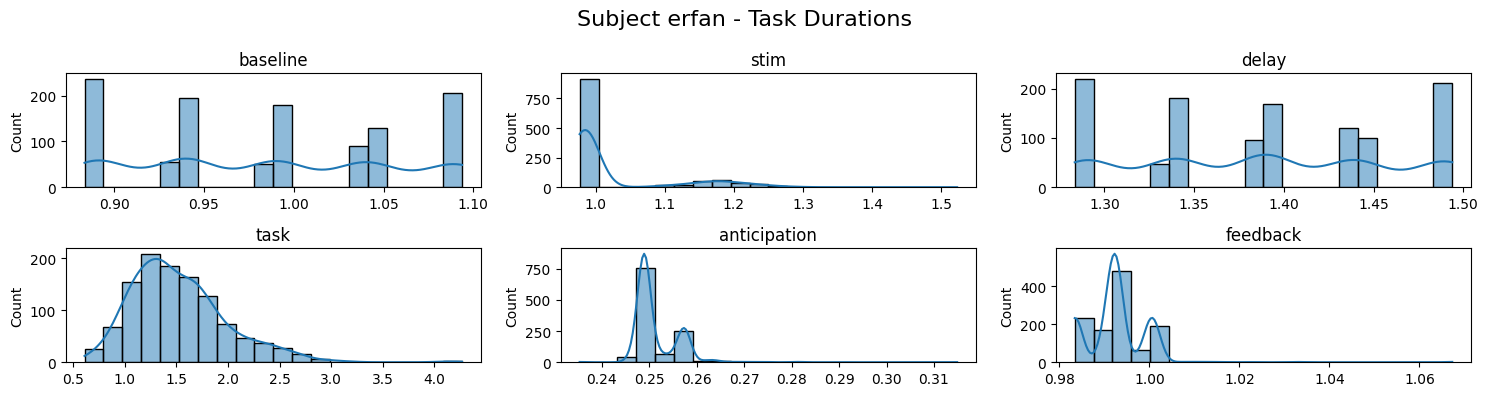

In [71]:
# create column for each phases's duration
expt_phases = ['baseline', 'stim', 'delay', 'task', 'anticipation', 'feedback']
for phase in expt_phases:
    df_analysis[f'{phase}_dur'] = df_analysis[f'{phase}.stopped'] - df_analysis[f'{phase}.started']

# sid, check if these are needed replacements
df_analysis['stim_dur'] = df_analysis['stim.stopped'] - df_analysis['target_stim.started']
df_analysis['feedback_dur'] = df_analysis['feedback.stopped'] - df_analysis['no_resp_text.started']

fig, axs = plt.subplots(2, 3, figsize=(15, 4))
axs, ax = axs.flatten(), 0

for expt_phase in expt_phases:

    sns.histplot(df_analysis[f'{expt_phase}_dur'], bins=20, kde=True, ax=axs[ax])
    axs[ax].set(title=expt_phase, xlabel='', ylabel='Count')
    ax += 1

plt.suptitle(f'Subject {subj} - Task Durations', fontsize=16)
plt.tight_layout()
plt.show()

# print which trials with feedback duration < .99
# short_feedback = df_analysis.loc[df_analysis['feedback_dur'] < 0.998]
# print(f'{len(short_feedback)} trials: {short_feedback.index.tolist()}')

### chose what df to analyze

In [74]:
print(subjs)
subj = subjs[0]
df_analysis = df_subjs[df_subjs['subj'] == subj].copy()
df_analysis[disp_cols]

[202509, 'tori', 'amisha', 'adam', 'erfan']


,sess_type,sess_flip,shape_order,dir_flip,target_pos,shape,valence,class_true,div_pos,div_pos_aligned,stim_pos,stim_pos_aligned,chosen_pos,chosen_pos_aligned,class_pred,err_type,right_bias,abs_diff_pos
1,A,0.0,flat_curv,1.0,0.38,curv,pen,0.0,0.0,-0.0,-0.38,-0.38,0.060,-0.060,0.0,0.0,0.320,0.320
2,A,0.0,curv_flat,0.0,-0.34,curv,pen,0.0,0.0,0.0,-0.34,-0.34,-0.028,-0.028,0.0,0.0,0.312,0.312
3,A,0.0,flat_curv,1.0,0.34,curv,pen,0.0,0.0,-0.0,-0.34,-0.34,0.000,-0.000,0.0,0.0,0.340,0.340
4,A,0.0,curv_flat,0.0,-0.30,curv,pen,0.0,0.0,0.0,-0.30,-0.30,-0.232,-0.232,0.0,0.0,0.068,0.068
5,A,0.0,flat_curv,1.0,0.30,curv,pen,0.0,0.0,-0.0,-0.30,-0.30,0.104,-0.104,0.0,0.0,0.196,0.196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,A,0.0,flat_curv,1.0,-0.34,flat,rew,1.0,-0.2,0.2,0.34,0.34,-0.200,0.200,0.0,-1.0,-0.140,0.140
236,A,0.0,curv_flat,0.0,0.38,flat,rew,1.0,0.2,0.2,0.38,0.38,0.244,0.244,1.0,0.0,-0.136,0.136
237,A,0.0,flat_curv,1.0,-0.38,flat,rew,1.0,-0.2,0.2,0.38,0.38,-0.204,0.204,1.0,0.0,-0.176,0.176
238,A,0.0,curv_flat,0.0,0.38,flat,rew,1.0,0.2,0.2,0.38,0.38,0.256,0.256,1.0,0.0,-0.124,0.124


## 1. analyses by valence & compression

In [75]:
'correct' in df_analysis.columns

True

condition
rew_comp    79
baseline    77
pen_comp    76
Name: count, dtype: int64
correct
1.0    189
0.0     43
Name: count, dtype: int64
outcome
 3.0    100
 1.0     89
-3.0     29
-1.0     14
Name: count, dtype: int64


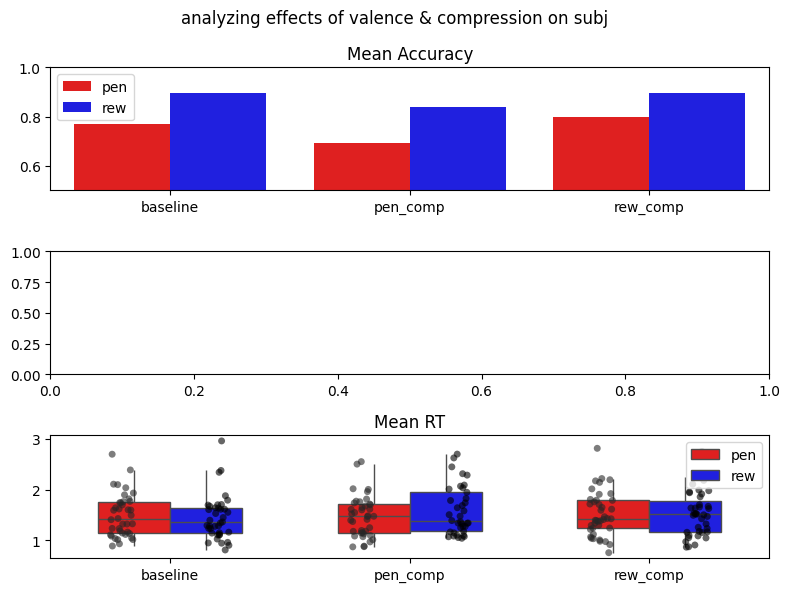

In [78]:
# df_plot = df_hard.copy()
df_plot = df_analysis.copy()

df_plot['correct'] = df_plot['correct'].apply(lambda x: 0 if x == -1 else x)
print(df_plot['condition'].value_counts())
print(df_plot['correct'].value_counts())
print(df_plot['outcome'].value_counts())

fig, axes = plt.subplots(3, 1, figsize=(8, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence & compression on subj')
palette, hue_order = {'rew': 'blue', 'pen': 'red'}, ['pen', 'rew']

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='condition', y='correct', hue='valence', hue_order=hue_order, palette = palette, ax=ax, errorbar=None)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')
ax.legend()

# 2.
# ax = axes[1]
# sns.boxplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order,
#             palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=df_plot, x='condition', y='MAE_unnormed', hue='valence', hue_order = hue_order, 
#               dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Mean Absolute Error')
# ax.legend()

# 3.
ax = axes[2]
sns.boxplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', hue_order = hue_order,
            palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)
sns.stripplot(data=df_plot, x='condition', y='trials.submit_resp.rt', hue='valence', 
              dodge=True, color='black', alpha=0.6, jitter=True, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()

## analyses by valence space

percept_space
curvy         60
very_curvy    60
very_flat     60
flat          60
Name: count, dtype: int64


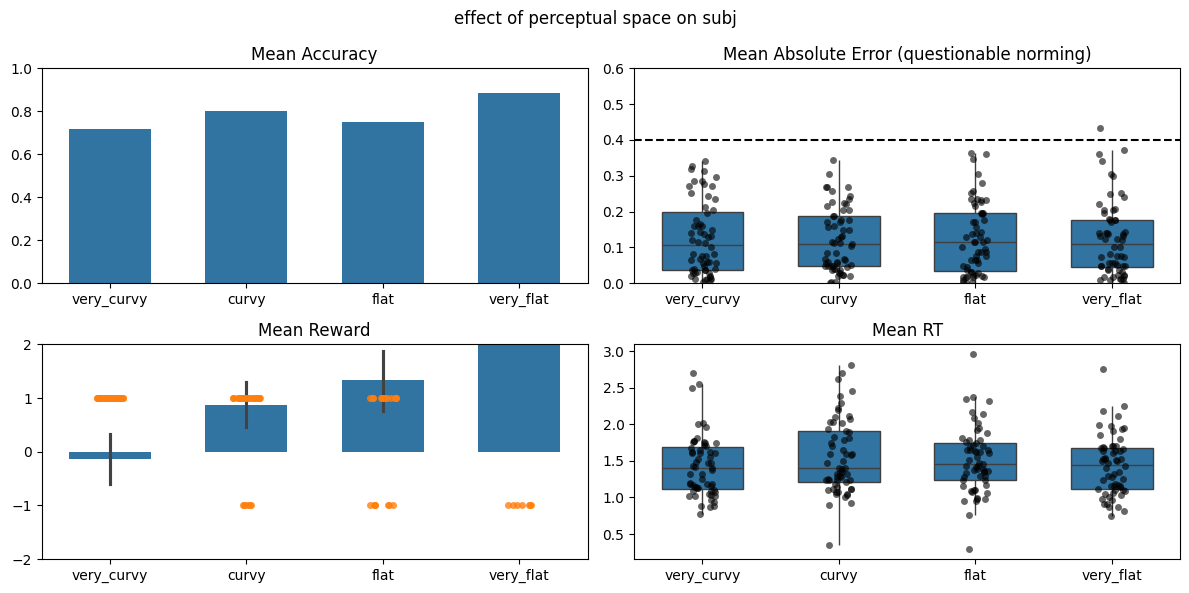

In [ ]:
df_plot = df.copy()

conditions = [
    (-0.4 < df_plot['stim_pos']) & (df_plot['stim_pos'] < -0.2),
    (-0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0),
    (0 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.2),
    (0.2 < df_plot['stim_pos']) & (df_plot['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df_plot['percept_space'] = np.select(conditions, percept_labels, default= 'undefined')

# arnav's percept space will be flipped
print(df_plot['percept_space'].value_counts())

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effect of perceptual space on subj')

# 1. accuracy
ax = axes[0]
sns.barplot(data=df_plot, x='percept_space', y='correct', width=0.6, ax=ax, errorbar=None, order=percept_labels)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, 1)
ax.set_title('Mean Accuracy')

# 2. MAE
ax = axes[1]
sns.boxplot(data=df_plot, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='MAE_normed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, order=percept_labels, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(0, .6)
ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
ax.set_title('Mean Absolute Error (questionable norming)')

# 3. reward
ax = axes[2]
sns.barplot(data=df_plot, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, order=percept_labels, ax=ax)
sns.stripplot(data=df_plot, x='percept_space', y='outcome', dodge=True, alpha=0.8, jitter=True, order=percept_labels, legend=False, ax=ax)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')

# 4. RT
ax = axes[3]
sns.boxplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax, order=percept_labels)
sns.stripplot(data=df_plot, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, order=percept_labels, legend=True, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')

plt.tight_layout()
plt.show()



## pred-true position

In [ ]:
df

,thisN,thisTrialN,thisRepN,blockN,run,condition,trial_key,stim_file_pos,stim_pos,noise_pos,...,MAE_normed,dist,avg_speed,choice,base_dur,stim_dur,delay_dur,task_dur,anticipation_dur,feedback_dur
0,0.0,0.0,0.0,1.0,1.0,baseline,10.0,1.1,-0.18,1.0,...,0.244,0.200,0.083771,0,0.984188,0.983078,1.433738,2.415475,0.248761,0.983505
1,1.0,1.0,0.0,1.0,1.0,baseline,7.0,0.7,-0.26,1.0,...,0.160,0.280,0.158248,0,0.885377,0.983446,1.334925,1.797696,0.248723,0.983523
2,2.0,2.0,0.0,1.0,1.0,baseline,37.0,3.7,0.34,3.0,...,0.204,0.000,0.000000,0,0.935482,0.983486,1.383974,1.031866,0.248771,0.983545
3,3.0,3.0,0.0,1.0,1.0,baseline,14.0,1.5,-0.10,1.0,...,0.036,0.144,0.116655,0,0.984408,0.983455,1.334276,1.264647,0.248702,0.983508
4,4.0,4.0,0.0,1.0,1.0,baseline,8.0,0.9,-0.22,1.0,...,0.276,0.120,0.110404,0,1.084197,0.983425,1.484996,1.113990,0.248821,0.983528
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,35.0,35.0,0.0,6.0,2.0,flat_comp,212.0,2.3,0.06,3.0,...,0.004,0.424,0.236969,0,1.033963,0.983397,1.383564,1.815711,0.248858,0.983503
236,36.0,36.0,0.0,6.0,2.0,flat_comp,234.0,3.7,0.34,1.0,...,0.072,0.056,0.063931,0,0.984186,0.983398,1.383773,0.898815,0.248867,0.983530
237,37.0,37.0,0.0,6.0,2.0,flat_comp,232.0,3.7,0.34,1.0,...,0.076,0.464,0.308288,0,0.935115,0.983480,1.385358,1.530604,0.248730,0.983582
238,38.0,38.0,0.0,6.0,2.0,flat_comp,205.0,1.5,-0.10,3.0,...,0.204,0.112,0.108230,0,0.933741,0.983458,1.434310,1.065048,0.248811,0.983500


In [ ]:
for run, run_df in df.groupby('run'):
    run_df
    break